# 테스트: STL Analyzer (계절성/추세 강도 분석기)

`pkgs/data_pipeline/stl_analyzer.py`에 구현된 `Stl_decomposition` 클래스가
시계열 데이터의 계절성 강도(QS)와 추세 강도(QT)를 올바르게 계산하는지 테스트합니다.

이 QS 점수는 "Understanding..." 논문에 따라 이 데이터가 LLM 친화적인지 판별하는
'지능형 라우터'의 핵심 지표가 됩니다.

In [2]:
%pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 11.5 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# --- 프로젝트 루트 경로 설정 ---
# 이 노트북(notebooks/)에서 pkgs/를 import하기 위해
# 상위 폴더(ship-ai/)를 경로에 추가합니다.
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"Added project root to sys.path: {PROJECT_ROOT}")
# ---------------------------------

# 1. STL 분석기 클래스 Import
try:
    from pkgs.data_pipeline.stl_analyzer import Stl_decomposition
    print("Stl_decomposition class imported successfully!")
except ImportError as e:
    print(f"Error importing Stl_decomposition: {e}")
    print("Please check if 'pkgs/data_pipeline/stl_analyzer.py' exists.")
    
# 2. (비교용) statsmodels의 기본 STL plot도 import
from statsmodels.tsa.seasonal import STL as StatsmodelsSTL

Stl_decomposition class imported successfully!


In [7]:
# --- 설정값 (삼성중공업 테스트용) ---

# (중요!) data/silver/prices_daily/ 폴더에 010140.csv 파일이 있는지 확인!
TEST_TICKER = "010140" # 삼성중공업
DATA_FILE_PATH = os.path.join(PROJECT_ROOT, "data", "silver", "prices_daily", f"{TEST_TICKER}.csv")

# (중요!) STL 분석에 사용할 주기(Period) 설정
#
# [옵션 1] 1년 주기성을 테스트할 경우 (권장)
# (CSV 파일에 최소 2년 = 504일치 데이터가 필요합니다)
PERIOD_TO_TEST = 252
# --------------------------------------

# 1. 데이터 로드
try:
    df = pd.read_csv(DATA_FILE_PATH, parse_dates=['date'])
    print(f"Successfully loaded data for {TEST_TICKER}. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_FILE_PATH}")
    print("Please check TEST_TICKER and file location.")

# 2. STL 분석기에 넣을 pd.Series 준비 (날짜 인덱스, 단일 값)
if 'date' in df.columns and 'close' in df.columns:
    data_series = df.set_index('date')['close'].dropna()
    print(f"Data series prepared. Length: {len(data_series)}")
    
    # 3. (필수) 데이터가 주기보다 2배 이상 긴지 확인
    if len(data_series) < PERIOD_TO_TEST * 2:
        print(f"--- ⚠️  Warning! ---")
        print(f"Data length ({len(data_series)}) is too short for the chosen period ({PERIOD_TO_TEST}).")
        print(f"STL analysis requires at least 2 * period = {PERIOD_TO_TEST * 2} data points for reliable results.")
        print(f"Consider using more data (e.g., 2+ years) or testing a smaller period (e.g., PERIOD_TO_TEST = 63 for quarterly).")
    else:
        print(f"Data length ({len(data_series)}) is sufficient for period ({PERIOD_TO_TEST}). Proceeding.")
else:
    print("Error: 'date' or 'close' column not found in the CSV. Please check the file format.")

Successfully loaded data for 010140. Shape: (732, 6)
Data series prepared. Length: 732
Data length (732) is sufficient for period (252). Proceeding.


Plotting original data and statsmodels STL decomposition...


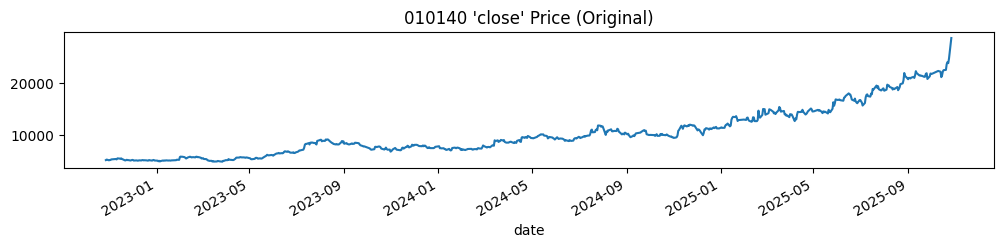

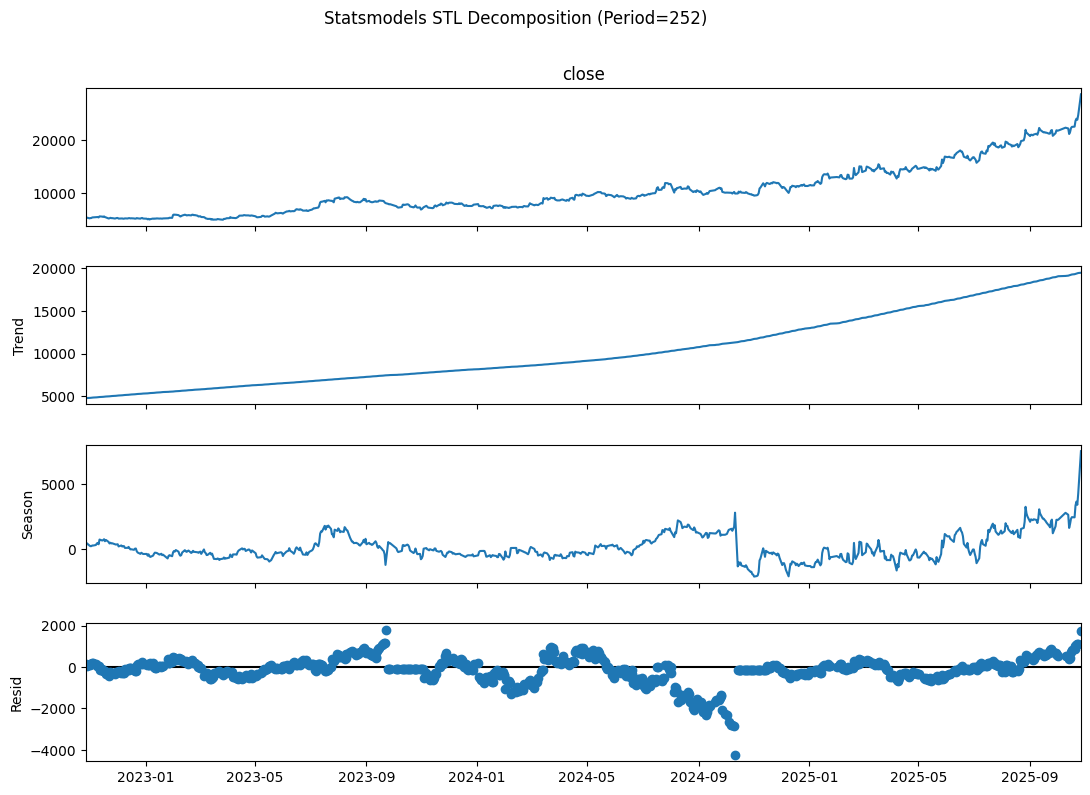

In [11]:
# (선택 사항) 데이터가 어떻게 생겼는지, STL 분해가 잘 되는지 눈으로 확인합니다.
print("Plotting original data and statsmodels STL decomposition...")

# 1. 원본 데이터 Plot
data_series.plot(title=f"{TEST_TICKER} 'close' Price (Original)", figsize=(12, 2))
plt.show()

# 2. statsmodels의 기본 STL 분해 Plot
# (Stl_decomposition 클래스 내부에서도 동일한 로직을 사용합니다)
try:
    stl_result = StatsmodelsSTL(data_series, period=PERIOD_TO_TEST).fit()
    fig = stl_result.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f"Statsmodels STL Decomposition (Period={PERIOD_TO_TEST})", y=1.02)
    plt.show()
except ValueError as e:
    print(f"Could not plot STL decomposition: {e}")

In [10]:
print(f"--- Running Stl_decomposition.strength() test ---")
print(f"Target Series: 'close' (Length={len(data_series)})")
print(f"Period: {PERIOD_TO_TEST}")

try:
    # 1. 분석기 인스턴스 생성
    analyzer = Stl_decomposition(data=data_series, period=PERIOD_TO_TEST)
    
    # 2. 강도 계산 메소드 호출
    trend_strength, seas_strength = analyzer.strength()
    
    print("\n--- Test Result ---")
    print(f"Trend Strength (QT):     {trend_strength:.4f}")
    print(f"Seasonality Strength (QS): {seas_strength:.4f}")
    
except Exception as e:
    print(f"\nAn error occurred during analysis: {e}")

--- Running Stl_decomposition.strength() test ---
Target Series: 'close' (Length=732)
Period: 252

--- Test Result ---
Trend Strength (QT):     0.9782
Seasonality Strength (QS): 0.7209
